<a href="https://colab.research.google.com/github/rdion-ken/mbti-text-analysis/blob/main/MBTI_Text_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Psychology of Social Media Behavior and Online Personas

## 1. Overview and Goal

This project explores how **personality traits shape language patterns in online self expression**.

Using the **MBTI 500 Personality Types Dataset**, the study analyzes how distinct personality categories correspond to unique linguistic signatures.

Rather than focusing on tone or syntax, the project emphasizes **quantitative text analysis and machine learning classification.**

By examining the relationship between MBTI dimensions and text features, it uncovers whether personality differences can be inferred from the words people use, even after text standardization.

Specifically, this study also aims to:
- Identify **linguistic features** that distinguish personality types.
- Train and evaluate a **text classification model** capable of predicting MBTI traits from language data.
- Visualize the relationships between **personality dimensions** and **dominant lexical patterns** within the dataset.

## 2. Dataset Description

**Dataset:** MBTI 500 Personality Types Dataset  
**Source:** [Kaggle – MBTI 500 Dataset](https://www.kaggle.com/datasets/zeyadkhalid/mbti-personality-types-500-dataset/data) (Zeyad Khalid, 2021)  

This dataset contains approximately 106,000 preprocessed records of user posts paired with MBTI personality types, stored in `mbti_500.csv`

**Structure:**
- `type` → 16 MBTI personality type (e.g. INTJ, ENFP)  
- `posts` → 500 word text sample from Reddit/PersonalityCafe  

**Timeframe:** Posts originally gathered between 2016–2019.  Cleaned in 2021.  

Since the text has been preprocessed punctuation, stopwords, and URLs removed, and all samples standardized to equal length, this dataset is particularly well suited for **machine learning classification tasks.**

It provides a large dataset ideal for identifying **lexical patterns** and **predictive linguistic features** associated with personality types.

## 3. Methodology and Approach

### Step 1: Data Access and Library Import
Import core libraries and download the MBTI dataset directly for reproducibility.


In [ ]:
# Import core libraries
import pandas as pd
import numpy as np
import gdown
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning tools
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# For linguistic insights later
import nltk
from nltk import pos_tag
from collections import Counter
nltk.download('averaged_perceptron_tagger')

# Display options
pd.set_option('display.max_colwidth', 150)
pd.options.display.float_format = '{:.2f}'.format

# Download MBTI dataset
url = "https://drive.google.com/uc?id=1KM-1SAIhKhLhdQawPKBoyR3vGBCTJPzV"
output = "mbti_500.csv"

print("Downloading dataset...")
gdown.download(url, output, quiet=False)

# Load dataset
try:
    data = pd.read_csv(output)
    print(f"Dataset loaded successfully. Shape: {data.shape}")
    print("Columns:", list(data.columns))
except Exception as e:
    print("Error loading dataset:", e)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


Downloading...
From (original): https://drive.google.com/uc?id=1KM-1SAIhKhLhdQawPKBoyR3vGBCTJPzV
From (redirected): https://drive.google.com/uc?id=1KM-1SAIhKhLhdQawPKBoyR3vGBCTJPzV&confirm=t&uuid=11717122-9f71-4ee0-beac-1d73fecc69f3
To: /content/mbti_500.csv
100%|██████████| 346M/346M [00:05<00:00, 62.5MB/s]


Dataset loaded successfully. Shape: (106067, 2)
Columns: ['posts', 'type']


### Step 2: Data Cleaning and Feature Engineering

Since the text in this dataset has already been lemmatized, standardized, and stripped of punctuation, stopwords, and URLs, it is well suited for machine learning based text classification.

This stage focuses on preparing the dataset for modeling by ensuring data integrity and engineering structured features from the MBTI types.


1. Remove duplicates and missing values to ensure dataset consistency.
2. Verify text normalization, confirming that all entries are lowercase and alphabetic.
3. Split MBTI personality types into four binary columns representing the individual psychological dimensions:
*   Introversion (I) vs. Extraversion (E)
*   Sensing (S) vs. Intuition (N)
*   Thinking (T) vs. Feeling (F)
*   Judging (J) vs. Perceiving (P)
4. Prepare the processed dataset for vectorization and machine learning classification in the next step.

In [ ]:
import re
from tqdm.notebook import tqdm
tqdm.pandas(desc="Processing text features")

# Remove duplicates and missing values
data.drop_duplicates(inplace=True)
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)

# Split MBTI types into binary dimensions
data["I_E"] = data["type"].apply(lambda x: 1 if "I" in x else 0)  # 1 = Introvert, 0 = Extrovert
data["S_N"] = data["type"].apply(lambda x: 1 if "S" in x else 0)  # 1 = Sensing, 0 = Intuitive
data["T_F"] = data["type"].apply(lambda x: 1 if "T" in x else 0)  # 1 = Thinking, 0 = Feeling
data["J_P"] = data["type"].apply(lambda x: 1 if "J" in x else 0)  # 1 = Judging, 0 = Perceiving

# Overview of class balance
print("Data cleaning completed.")
print(f"Dataset shape after cleaning: {data.shape}")
print("\nPersonality type distribution:")
print(data['type'].value_counts().head(10))

# Preview a few samples
display(data[["type", "posts"]].head())


Data cleaning completed.
Dataset shape after cleaning: (106067, 6)

Personality type distribution:
type
INTP    24961
INTJ    22427
INFJ    14963
INFP    12134
ENTP    11725
ENFP     6167
ISTP     3424
ENTJ     2955
ESTP     1986
ENFJ     1534
Name: count, dtype: int64


,type,posts
0,INTJ,know intj tool use interaction people excuse antisocial truly enlighten mastermind know would count pet peeze something time matter people either ...
1,INTJ,rap music ehh opp yeah know valid well know fact people like socialize party even personality let alone personality type reason remain mystery lik...
2,INTJ,preferably p hd low except wew lad video p mind good reason agree statement relationship become difficu maintain people involve different stag lif...
3,INTJ,drink like wish could drink red wine give headache almost instantaneously apparently people really sensitive byproduct red wine esfp bite place bl...
4,INTJ,space program ah bad deal meing freelance max seem get still upgrade hauler connie hate fut want build manage team play career restrict chemistry ...


### Step 3: Save Cleaned Dataset
After verifying data integrity and preparing MBTI dimension columns, we export the cleaned dataset for reuse and modeling.


In [ ]:
data.to_csv("clean_mbti_500.csv", index=False)
print("Cleaned dataset saved as clean_mbti_500.csv")


Cleaned dataset saved as clean_mbti_500.csv


### Step 4: Analyze N-gram Frequencies

This step explores the most common word patterns (unigrams, bigrams, trigrams) used by different personality types.

By identifying frequent word combinations, we can infer stylistic and thematic tendencies in how individuals of varying MBTI types express themselves.

Even though the dataset is preprocessed and standardized, word frequency patterns can still reveal meaningful **lexical preferences** (“feel like” for Feeling types vs. “think about” for Thinking types).

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm
import pandas as pd

# Load the cleaned dataset
data = pd.read_csv("clean_mbti_500.csv")

def get_top_ngram(corpus, n=None, num_words=10):
    vec = CountVectorizer(stop_words='english', ngram_range=(n, n))
    bag = vec.fit_transform(corpus)
    sum_words = bag.sum(axis=0)
    words_freq = [(word, int(sum_words[0, idx])) for word, idx in vec.vocabulary_.items()]
    return sorted(words_freq, key=lambda x: x[1], reverse=True)[:num_words]

ngram_analysis = {}

# Use tqdm progress bar for each MBTI type
for mbti_type in tqdm(data['type'].unique(), desc="Analyzing MBTI Types"):
    type_posts = data.loc[data['type'] == mbti_type, 'posts']
    top_bigrams = get_top_ngram(type_posts, n=2, num_words=10)
    top_trigrams = get_top_ngram(type_posts, n=3, num_words=10)
    ngram_analysis[mbti_type] = {
        'bigrams': top_bigrams,
        'trigrams': top_trigrams
    }

# Display sample output
for mbti_type in list(ngram_analysis.keys())[:3]:
    print(f"\nTop N-grams for {mbti_type}:")
    print("  Bigrams:", ngram_analysis[mbti_type]['bigrams'])
    print("  Trigrams:", ngram_analysis[mbti_type]['trigrams'])
    print("-" * 40)


Analyzing MBTI Types: 100%|██████████| 16/16 [10:46<00:00, 40.40s/it]


Top N-grams for INTJ:
  Bigrams: [('feel like', 11607), ('sound like', 6912), ('make sense', 5326), ('high school', 4358), ('thing like', 4196), ('make feel', 3867), ('look like', 3802), ('people like', 3735), ('spend time', 3553), ('people think', 3528)]
  Trigrams: [('bsp amp bsp', 860), ('amp bsp amp', 859), ('make feel good', 697), ('spend lot time', 663), ('jackass jackass jackass', 653), ('make feel like', 626), ('play video game', 565), ('ni te fi', 442), ('te fi se', 391), ('meet new people', 384)]
----------------------------------------

Top N-grams for INTP:
  Bigrams: [('feel like', 13350), ('sound like', 7456), ('make sense', 6719), ('high school', 4741), ('thing like', 4693), ('look like', 4530), ('make feel', 4351), ('people think', 4061), ('people like', 3793), ('spend time', 3247)]
  Trigrams: [('make feel good', 804), ('entp entp entp', 775), ('make feel like', 701), ('play video game', 676), ('spend lot time', 635), ('penis penis penis', 518), ('post remove follow',

### Step 5: Part of Speech Frequency Analysis

The goal here is to quantify how each MBTI type uses different grammatical categories nouns, verbs, adjectives, pronouns, etc. using a representative sample of posts (~500 per MBTI type).

*   Intuitives might use more adjectives/adverbs (abstract or descriptive language).
*   Thinkers might favor nouns and verbs (analytical, direct phrasing).
*   Feelers might retain more pronouns (relational focus).


Approch:
*   Apply spaCy to compute POS ratios per post.
*   Aggregate ratios by MBTI type for comparative insights.




In [ ]:
import pandas as pd
from tqdm.auto import tqdm
import spacy
from collections import Counter

# Load cleaned dataset
data = pd.read_csv("clean_mbti_500.csv")

# Stratified sampling: ~500 posts per MBTI type
sampled_data = data.groupby('type', group_keys=False).apply(lambda x: x.sample(min(len(x), 500), random_state=42)).reset_index(drop=True)
print(f"Sampled dataset shape: {sampled_data.shape}")

# Load spaCy model
!python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])

# Define POS categories
pos_map = {
    "NOUN": ["NOUN", "PROPN"],
    "VERB": ["VERB", "AUX"],
    "ADJ": ["ADJ"],
    "ADV": ["ADV"],
    "PRON": ["PRON"]
}

# Function to compute POS ratios
def get_pos_ratios(text):
    doc = nlp(text)
    counts = Counter()
    for token in doc:
        for pos_category, spacy_tags in pos_map.items():
            if token.pos_ in spacy_tags:
                counts[pos_category] += 1
                break
    total = sum(counts.values()) or 1
    return {f"{pos}_ratio": counts[pos]/total for pos in pos_map.keys()}

# Apply POS analysis to the sampled dataset
tqdm.pandas(desc="POS analysis")
pos_features = sampled_data['posts'].progress_apply(get_pos_ratios)
pos_df = pd.DataFrame(list(pos_features))

# Combine results with MBTI types
sampled_pos_data = pd.concat([sampled_data.reset_index(drop=True), pos_df], axis=1)

# Aggregate by MBTI type
pos_summary = sampled_pos_data.groupby("type")[["NOUN_ratio","VERB_ratio","ADJ_ratio","ADV_ratio","PRON_ratio"]].mean()
print("POS Frequency Summary (by MBTI type):")
display(pos_summary)


/tmp/ipython-input-3127334766.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_data = data.groupby('type', group_keys=False).apply(lambda x: x.sample(min(len(x), 500), random_state=42)).reset_index(drop=True)


Sampled dataset shape: (7523, 6)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 95.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


POS analysis:   0%|          | 0/7523 [00:00<?, ?it/s]

POS Frequency Summary (by MBTI type):


,NOUN_ratio,VERB_ratio,ADJ_ratio,ADV_ratio,PRON_ratio
type,,,,,
ENFJ,0.47,0.25,0.16,0.11,0.02
ENFP,0.47,0.25,0.16,0.11,0.02
ENTJ,0.50,0.23,0.16,0.10,0.02
ENTP,0.48,0.23,0.16,0.10,0.02
ESFJ,0.48,0.24,0.15,0.11,0.02
ESFP,0.48,0.24,0.15,0.11,0.02
ESTJ,0.55,0.21,0.14,0.09,0.02
ESTP,0.52,0.21,0.16,0.09,0.02
INFJ,0.46,0.25,0.16,0.11,0.02


### Step 6: TF-IDF Vectorization + Simple Classifier

Transforms the preprocessed text into a numerical representation using TF-IDF and train a simple classifier to predict MBTI personality traits. This serves as a proof of concept to show whether language patterns are predictive of personality types.



*   Use TF-IDF to vectorize text while capturing term importance.
*   Train a Logistic Regression model for multi-class classification.
*   Evaluate using accuracy and confusion matrix for interpretability.
*   Can optionally run on a subset for faster experimentation in Colab.






In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tqdm.auto import tqdm

# Load cleaned dataset
data = pd.read_csv("clean_mbti_500.csv")

# Optional: use a subset for faster testing (like 5000 posts)
# data = data.sample(5000, random_state=42)

# TF-IDF vectorization
tqdm.pandas(desc="Vectorizing text")
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X = vectorizer.fit_transform(tqdm(data['posts']))

# Target labels
y = data['type']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Logistic Regression classifier
clf = LogisticRegression(max_iter=500, multi_class='ovr', n_jobs=-1)
clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)

# Evaluation
acc = accuracy_score(y_test, y_pred)
print(f"Classifier Accuracy: {acc:.2f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=3))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=data['type'].unique())
cm_df = pd.DataFrame(cm, index=data['type'].unique(), columns=data['type'].unique())
print("\nConfusion Matrix:")
display(cm_df)


  0%|          | 0/106067 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Classifier Accuracy: 0.81

Classification Report:
              precision    recall  f1-score   support

        ENFJ      0.830     0.414     0.552       307
        ENFP      0.842     0.750     0.793      1233
        ENTJ      0.913     0.606     0.728       591
        ENTP      0.831     0.793     0.811      2345
        ESFJ      0.857     0.167     0.279        36
        ESFP      0.533     0.222     0.314        72
        ESTJ      0.928     0.667     0.776        96
        ESTP      0.960     0.839     0.895       397
        INFJ      0.806     0.840     0.823      2993
        INFP      0.793     0.819     0.806      2427
        INTJ      0.800     0.879     0.838      4486
        INTP      0.802     0.886     0.842      4992
        ISFJ      0.842     0.369     0.513       130
        ISFP      0.741     0.343     0.469       175
        ISTJ      0.877     0.402     0.551       249
        ISTP      0.872     0.717     0.787       685

    accuracy                  

,INTJ,INTP,ISFJ,ISFP,ISTJ,ISTP,ENFJ,ENFP,ENTJ,ENTP,ESFJ,ESFP,ESTJ,ESTP,INFJ,INFP
INTJ,3943,307,0,1,4,12,3,27,7,42,0,1,0,3,80,56
INTP,306,4423,2,2,1,14,2,9,6,89,1,0,1,4,56,76
ISFJ,13,14,48,1,0,2,1,5,1,9,0,2,0,0,15,19
ISFP,6,19,1,60,0,6,3,3,2,10,0,3,0,1,20,41
ISTJ,51,40,0,0,100,2,0,7,0,6,0,1,0,0,23,19
ISTP,48,90,1,1,1,491,1,4,0,23,0,0,0,1,14,10
ENFJ,15,22,0,0,1,1,127,20,5,14,0,0,2,0,72,28
ENFP,70,34,1,1,2,2,2,925,1,28,0,2,0,0,85,80
ENTJ,95,48,1,1,0,5,3,2,358,32,0,0,0,0,24,22
ENTP,125,234,1,3,1,7,1,23,3,1859,0,1,1,3,61,22


## 4. Exploratory Data Analysis (EDA)

### MBTI Dimension Distribution

*   See balance in I/E, S/N, T/F, J/P.






In [ ]:
dimension_stats = pd.DataFrame({
    "Dimension": ["I/E", "S/N", "T/F", "J/P"],
    "Majority": [
        "Introvert" if data["I_E"].mean() > 0.5 else "Extrovert",
        "Sensing" if data["S_N"].mean() > 0.5 else "Intuition",
        "Thinking" if data["T_F"].mean() > 0.5 else "Feeling",
        "Judging" if data["J_P"].mean() > 0.5 else "Perceiving"
    ],
    "Split": [
        f"{data['I_E'].mean():.1%} / {1-data['I_E'].mean():.1%}",
        f"{data['S_N'].mean():.1%} / {1-data['S_N'].mean():.1%}",
        f"{data['T_F'].mean():.1%} / {1-data['T_F'].mean():.1%}",
        f"{data['J_P'].mean():.1%} / {1-data['J_P'].mean():.1%}"
    ],
    "Balance_Score": [
        abs(data['I_E'].mean() - 0.5),
        abs(data['S_N'].mean() - 0.5),
        abs(data['T_F'].mean() - 0.5),
        abs(data['J_P'].mean() - 0.5)
    ]
})
print("\nClass Balance by Dimension (0.0 = perfect balance, 0.5 = max imbalance):")
display(dimension_stats)


Class Balance by Dimension (0.0 = perfect balance, 0.5 = max imbalance):


,Dimension,Majority,Split,Balance_Score
0,I/E,Introvert,76.1% / 23.9%,0.26
1,S/N,Intuition,8.7% / 91.3%,0.41
2,T/F,Thinking,65.2% / 34.8%,0.15
3,J/P,Perceiving,41.9% / 58.1%,0.08


The dataset shows varying levels of imbalance across MBTI dimensions. The I/E dimension leans heavily toward Introverts (76%), while the S/N dimension is extremely skewed toward Intuition (91%). T/F favors Thinking (65%), and J/P is relatively balanced. These imbalances may affect downstream classification performance and should be considered when evaluating model results.

### Class Imbalance Analysis

*   Quantify type imbalance





In [ ]:
type_counts = data['type'].value_counts()
print(f"\nMost common type: {type_counts.index[0]} ({type_counts.iloc[0]} posts)")
print(f"Least common type: {type_counts.index[-1]} ({type_counts.iloc[-1]} posts)")
print(f"Imbalance ratio: {type_counts.iloc[0] / type_counts.iloc[-1]:.1f}x")
print(f"Types with <100 samples: {(type_counts < 100).sum()} out of 16")
print(f"Types with <50 samples: {(type_counts < 50).sum()} out of 16")


Most common type: INTP (24961 posts)
Least common type: ESFJ (181 posts)
Imbalance ratio: 137.9x
Types with <100 samples: 0 out of 16
Types with <50 samples: 0 out of 16


The dataset is highly imbalanced at the individual MBTI type level. INTP is the most represented type with ~25k posts, whereas ESFJ has only 181 posts, yielding an imbalance ratio of ~138x. Fortunately, all types have at least 50 posts, so none are completely missing, but this skew should be kept in mind for model training and evaluation.

### N-gram Diversity Analysis

*   Summary stats for language patterns





In [ ]:
ngram_diversity = {}
for mbti_type in ngram_analysis.keys():
    bigrams = ngram_analysis[mbti_type]['bigrams']
    if len(bigrams) > 0:
        total_bigrams = sum([count for _, count in bigrams])
        ngram_diversity[mbti_type] = {
            'total_bigrams': total_bigrams,
            'unique_in_top10': len(bigrams),
            'top1_concentration': bigrams[0][1] / total_bigrams if total_bigrams > 0 else 0,
            'most_common': bigrams[0][0]
        }

ngram_df = pd.DataFrame(ngram_diversity).T
print("\nN-gram Diversity by Type:")
print("(Higher concentration = more repetitive language)")
display(ngram_df.sort_values('top1_concentration', ascending=False))


N-gram Diversity by Type:
(Higher concentration = more repetitive language)


,total_bigrams,unique_in_top10,top1_concentration,most_common
INFP,36100,10,0.32,feel like
INFJ,43380,10,0.32,feel like
ENFP,18633,10,0.30,feel like
ESTJ,1520,10,0.29,det er
ENFJ,4544,10,0.28,feel like
ESFJ,614,10,0.27,feel like
ISFP,2594,10,0.26,feel like
ISFJ,2067,10,0.26,feel like
ISTJ,3297,10,0.24,feel like
INTP,56941,10,0.23,feel like


The N-gram analysis shows that while the top 10 bigrams are consistent across all types, the frequency of the most common bigram varies. ‘Feel like’ dominates for most types, reflecting a common informal phrasing in online posts. ESTP shows the lowest concentration of its top bigram, suggesting more lexical diversity, whereas INFP and INFJ have higher concentrations, indicating more repetitive language patterns.

### TF-IDF Feature Importance

*   Identify which words/bigrams are most predictive of each type.




In [ ]:
import numpy as np

print("\nTop 10 TF-IDF Features by MBTI Type:\n")
for idx, mbti_type in enumerate(clf.classes_):
    coefs = clf.coef_[idx]
    top_idx = np.argsort(coefs)[-10:]
    top_features = np.array(vectorizer.get_feature_names_out())[top_idx]
    top_weights = coefs[top_idx]

    print(f"{mbti_type}:")
    for feature, weight in zip(top_features, top_weights):
        print(f"  {feature}: {weight:.3f}")
    print()


Top 10 TF-IDF Features by MBTI Type:

ENFJ:
  fe: 2.755
  others: 2.895
  ban: 2.896
  haha: 2.933
  love: 2.973
  vulnerable: 3.082
  xd: 4.184
  lol: 5.775
  enfjs: 11.108
  enfj: 20.263

ENFP:
  adventure: 3.180
  te: 3.437
  super: 3.484
  dude: 4.058
  friend: 4.156
  ne: 5.040
  love: 5.082
  excite: 5.280
  enfps: 14.343
  enfp: 26.911

ENTJ:
  variant: 2.577
  te: 3.068
  set: 3.459
  goal: 3.496
  pack: 4.281
  award: 5.243
  card: 7.763
  trade: 8.222
  entjs: 10.985
  entj: 23.204

ENTP:
  fun: 5.078
  yeah: 5.302
  ne: 6.258
  lol: 6.271
  fuck: 6.981
  hahaha: 8.443
  shit: 8.736
  haha: 10.637
  entps: 15.340
  entp: 28.892

ESFJ:
  function: 1.573
  si: 1.660
  think: 1.691
  fe: 1.733
  thank: 1.771
  sensor: 2.492
  lol: 2.574
  type: 3.929
  esfjs: 6.287
  esfj: 10.762

ESFP:
  isfp: 1.898
  estp: 2.254
  sensor: 2.538
  fi: 2.886
  yeah: 2.964
  like: 3.690
  type: 3.830
  se: 5.103
  esfps: 5.516
  esfp: 13.227

ESTJ:
  af: 3.014
  type: 3.088
  si: 3.301
  de: 3.5

TF-IDF analysis highlights the words most distinctive to each MBTI type. Self-references (e.g., ‘enfp’, ‘intj’) dominate, as expected in a dataset labeled by personality. Beyond labels, lexical patterns reflect type tendencies: ENFPs emphasize relational and positive words (‘friend’, ‘love’, ‘excite’), INTJs focus on cognitive or planning related terms (‘te’, ‘plan’, ‘efficient’), and ISTPs/ESTPs feature more concrete or action oriented words (‘se’, ‘military’, ‘fix’). This preliminary observation suggests linguistic markers could differentiate personality types.

## 5. Visualization and Insights

### MBTI Type Distribution

/tmp/ipython-input-3699964066.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='type', order=data['type'].value_counts().index, palette="viridis")


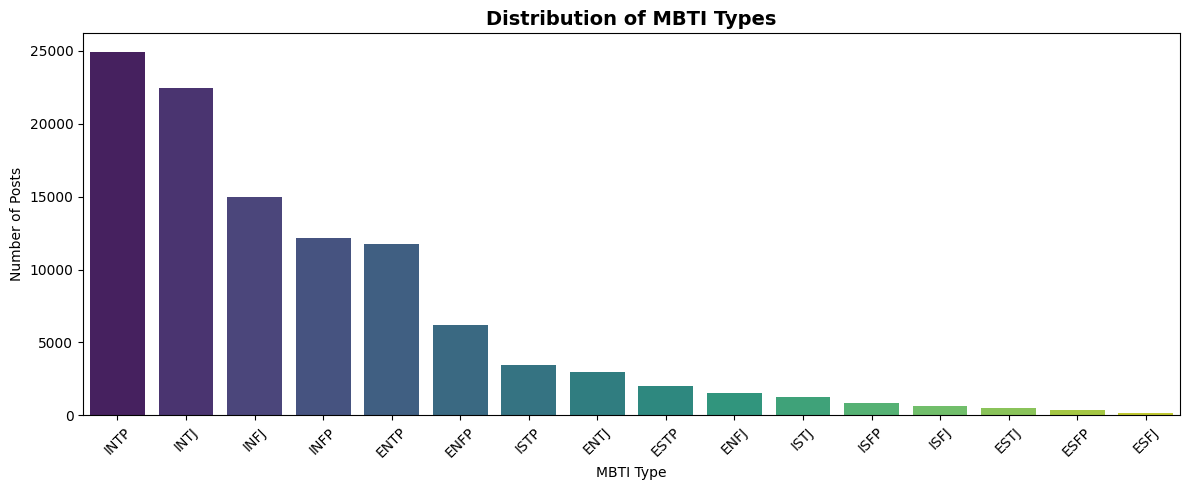

In [ ]:
plt.figure(figsize=(12,5))
sns.countplot(data=data, x='type', order=data['type'].value_counts().index, palette="viridis")
plt.xticks(rotation=45)
plt.title("Distribution of MBTI Types", fontsize=14, fontweight='bold')
plt.xlabel("MBTI Type")
plt.ylabel("Number of Posts")
plt.tight_layout()
plt.show()

## Dataset Overview: MBTI Posts Distribution

The dataset is heavily dominated by the four **Introverted-Intuitive (IN) types**:

| Type  | Approx. Posts |
|-------|---------------|
| INTP  | ~25,000       |
| INTJ  | ~22,500       |
| INFJ  | ~15,000       |
| INFP  | ~12,000       |

Other types, particularly **Extraverted-Sensing (ES)** types like ESFP, ESTP, and ESFJ, have very few posts (some < 500).  

### Observations
1. **Platform bias**: Data is sourced from websites like PersonalityCafe and Reddit, which attract users interested in **in depth discussions** and **anonymous interactions**. This skews the dataset toward **introverted-intuitive types**.
2. **Behavioral trends**: Extraverted-sensing types are more likely to use platforms like Instagram and Facebook, which emphasize **visual content, sensory experiences, and non-anonymous interactions**.
3. **Impact on modeling**: This imbalance can affect **model accuracy and fairness**, as predictions may overrepresent IN types while underrepresenting ES types.


### MBTI Dimension Distribution

/tmp/ipython-input-812841359.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data_plot, x="I_E_label", ax=axes[0,0], palette="pastel")
/tmp/ipython-input-812841359.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data_plot, x="S_N_label", ax=axes[0,1], palette="pastel")
/tmp/ipython-input-812841359.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data_plot, x="T_F_label", ax=axes[1,0], palette="pastel")
/tmp/ipython-input-812841359.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecat

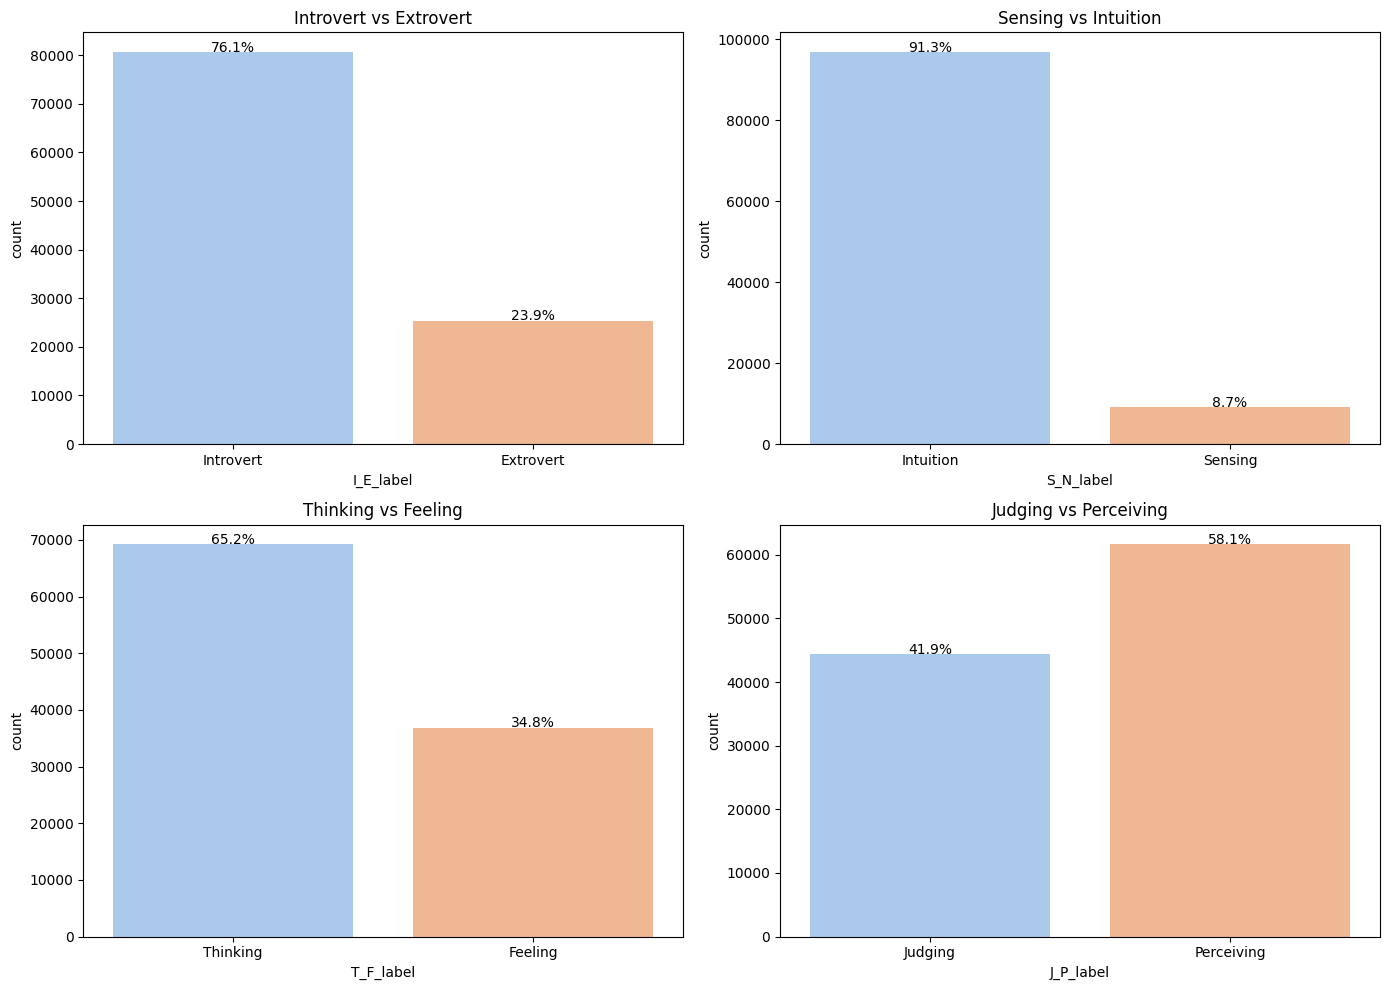

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Map binary to descriptive labels
data_plot = data.copy()
data_plot["I_E_label"] = data_plot["I_E"].map({1:"Introvert", 0:"Extrovert"})
data_plot["S_N_label"] = data_plot["S_N"].map({1:"Sensing", 0:"Intuition"})
data_plot["T_F_label"] = data_plot["T_F"].map({1:"Thinking", 0:"Feeling"})
data_plot["J_P_label"] = data_plot["J_P"].map({1:"Judging", 0:"Perceiving"})

# Create a 2x2 grid of readable plots
fig, axes = plt.subplots(2, 2, figsize=(14,10))
sns.countplot(data=data_plot, x="I_E_label", ax=axes[0,0], palette="pastel")
axes[0,0].set_title("Introvert vs Extrovert")

sns.countplot(data=data_plot, x="S_N_label", ax=axes[0,1], palette="pastel")
axes[0,1].set_title("Sensing vs Intuition")

sns.countplot(data=data_plot, x="T_F_label", ax=axes[1,0], palette="pastel")
axes[1,0].set_title("Thinking vs Feeling")

sns.countplot(data=data_plot, x="J_P_label", ax=axes[1,1], palette="pastel")
axes[1,1].set_title("Judging vs Perceiving")

# Add percentage labels on top of bars
for ax in axes.flatten():
    total = len(data_plot)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width()/2, height + 50, f"{height/total:.1%}",
                ha='center', fontsize=10)

plt.tight_layout()
plt.show()


### 1. Introvert vs Extrovert (I/E)
- **Introverts**: 76.1%  
- **Extroverts**: 23.9%  

The dataset is strongly **I-heavy**, reflecting its origins in long form online communities that naturally attract introverts. Linguistic patterns are therefore likely to be **introspective, analytical, and self focused**.

### 2. Sensing vs Intuition (S/N)
- **Intuition**: 91.3%  
- **Sensing**: 8.7%  

Extremely **N-dominant**, making S-type patterns underrepresented and less reliable. Most extracted linguistic features reflect **intuitive-style writing**, so ML models will likely struggle to detect S-types, resulting in the **lowest recall** along this dimension.

### 3. Thinking vs Feeling (T/F)
- **Thinking**: 65.2%  
- **Feeling**: 34.8%  

This is the **most balanced dimension**, with enough T and F posts to detect meaningful differences. Models should perform best here. We can analyze:
- **Analytical vs. emotional vocabulary**  
- **Argumentative vs. experiential phrasing**  
- **Logical vs. empathetic sentence structures**

### 4. Judging vs Perceiving (J/P)
- **Perceiving**: 58.1%  
- **Judging**: 41.9%  

Slightly skewed but not extreme. J/P linguistic differences remain **reliable for analysis**. P dominance aligns with the N/T dominance, reflecting that **NT and NP types dominate the dataset**.


### N-gram Frequency Visualization

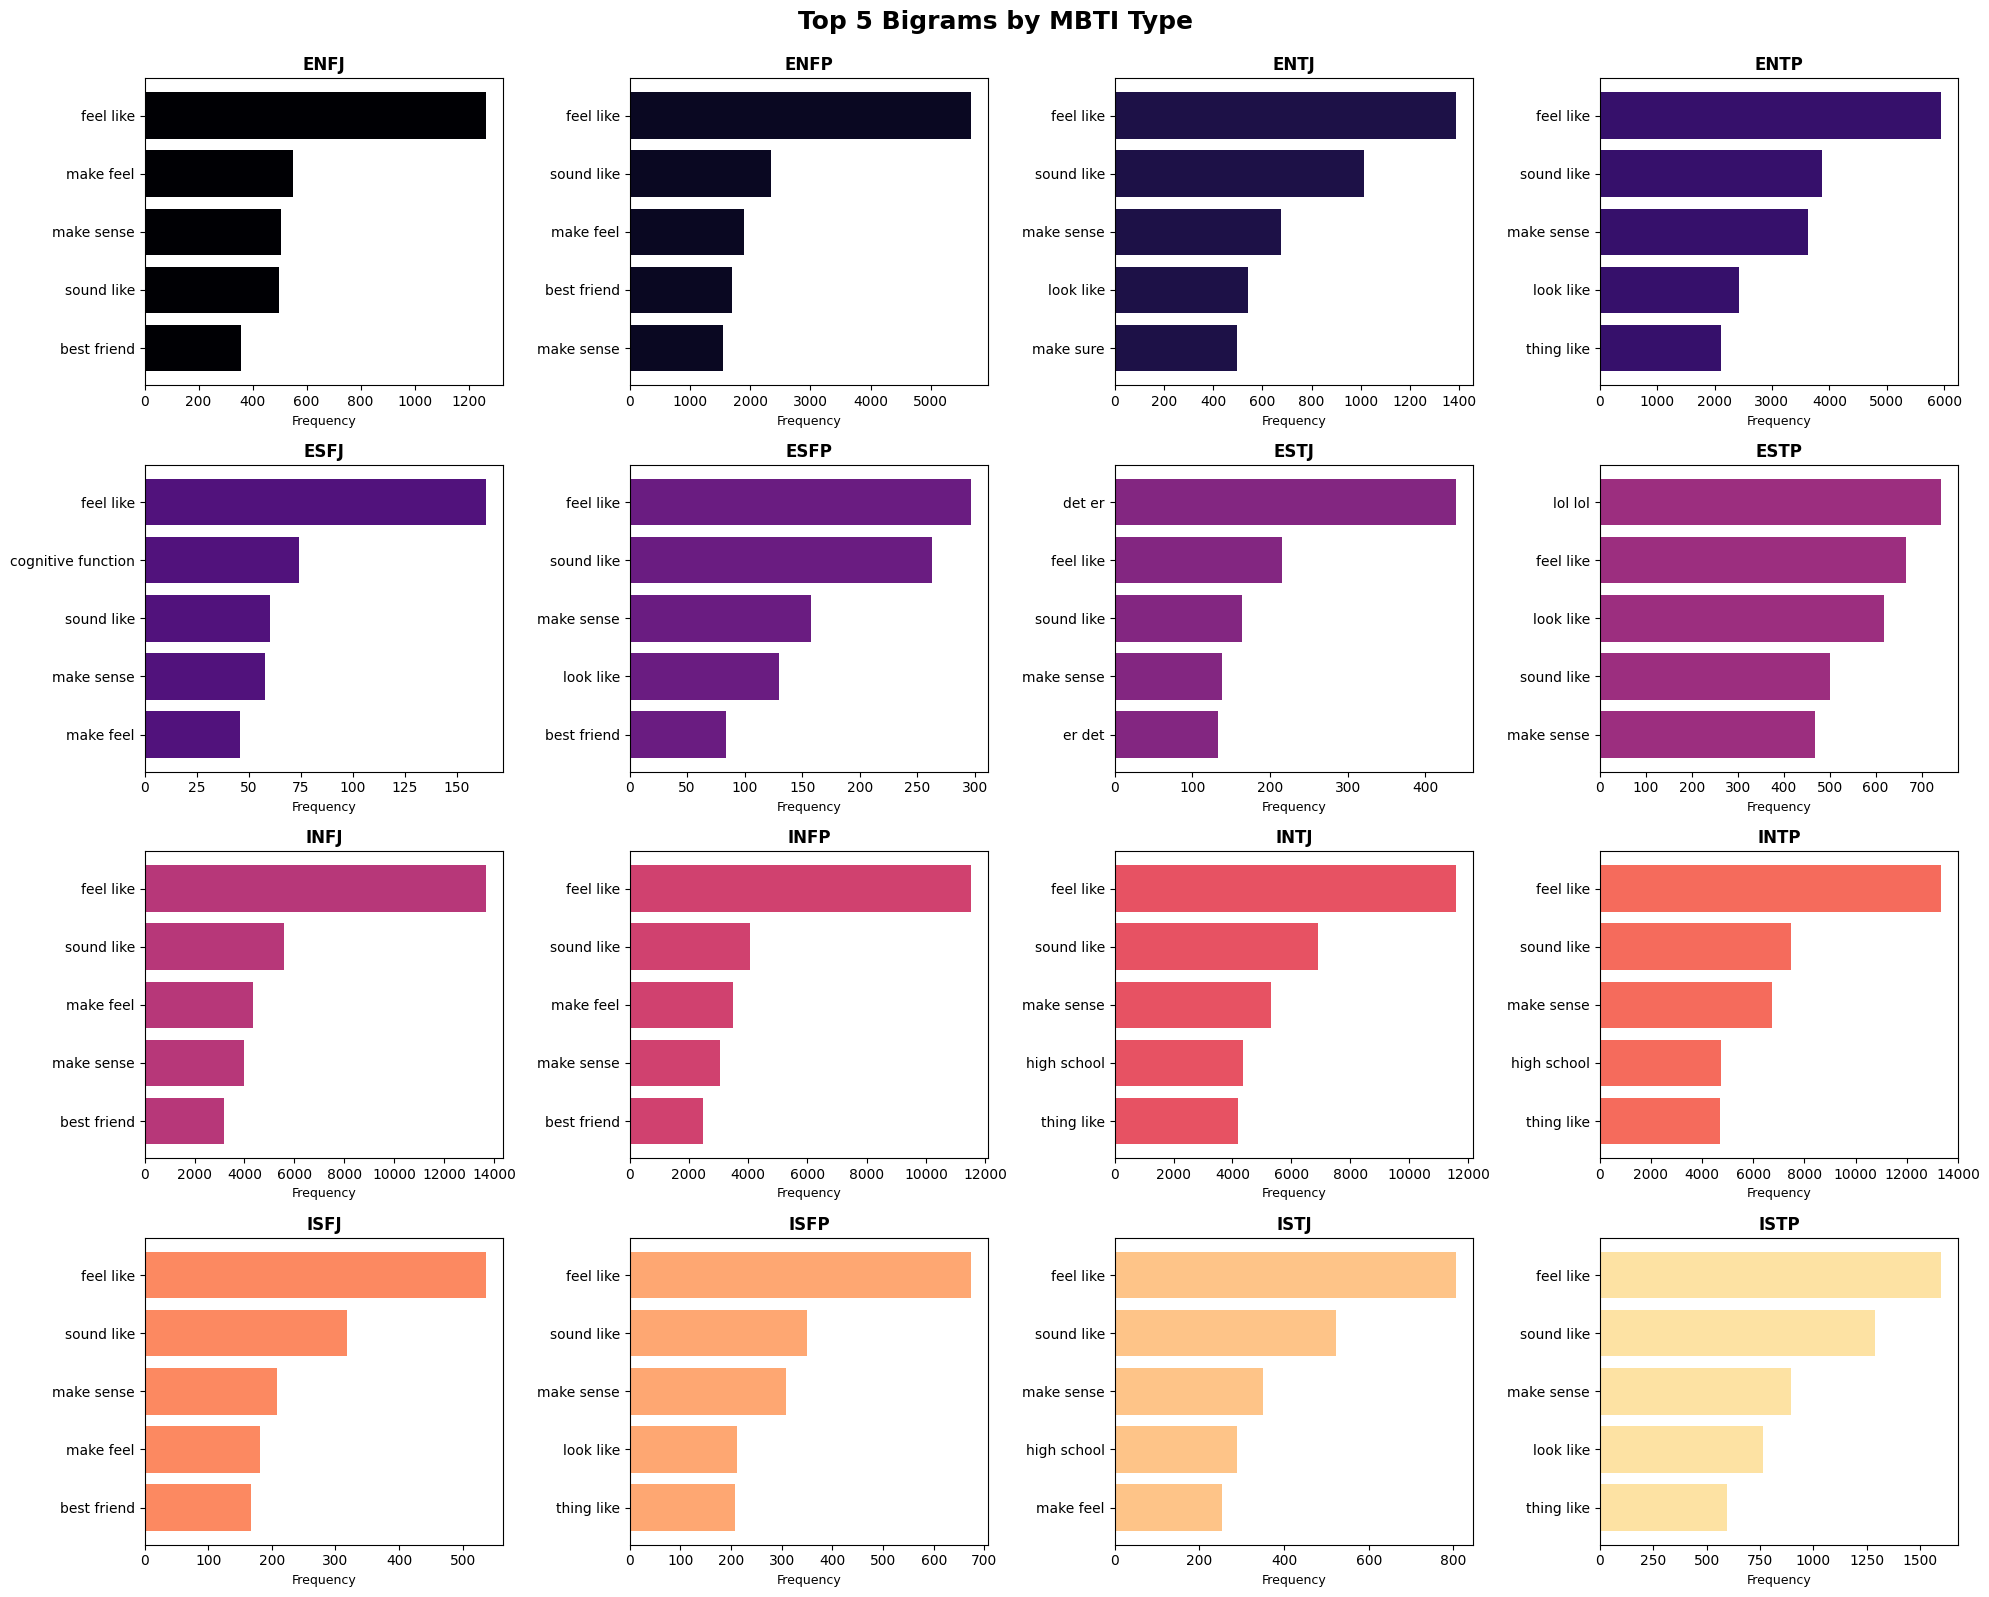

In [ ]:
# Create subplots for all 16 types
fig, axes = plt.subplots(4, 4, figsize=(20, 16))
axes = axes.flatten()

for idx, mbti_type in enumerate(sorted(ngram_analysis.keys())):
    top_bigrams = ngram_analysis[mbti_type]['bigrams']
    if len(top_bigrams) > 0:
        words, counts = zip(*top_bigrams[:5])
        axes[idx].barh(list(words), list(counts), color=plt.cm.magma(idx/16))
        axes[idx].set_title(mbti_type, fontweight='bold', fontsize=12)
        axes[idx].invert_yaxis()
        axes[idx].set_xlabel("Frequency", fontsize=9)
    else:
        axes[idx].text(0.5, 0.5, 'No data', ha='center', va='center')
        axes[idx].set_title(mbti_type, fontweight='bold')

plt.suptitle("Top 5 Bigrams by MBTI Type", fontsize=18, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

Across nearly all 16 MBTI types, **“feel like”** dominates as the most frequent bigram, except for **ESTP**.  

- **“Feel like” is not an emotional expression** but a **discourse marker**.  
  It often signals:
  - **Uncertainty:** “I feel like this means…”
  - **Opinion introduction:** “I feel like people forget…”  
- Its reflects **casual, introspective online communication**, typical of the MBTI dataset community (Reddit and PersonalityCafe).  
- Because it appears so frequently across all types, **“feel like” is not a discriminative linguistic feature** for MBTI classification.

### Outlier: ESTP
- **ESTP** stands out with bigrams such as **“lol lol”**, indicating **more reactive and informal language**.  
- This aligns with typical personality descriptions of ESTPs as **action oriented** and **less introspective** compared to IN-dominant types.

### Additional Anomaly: ESTJ
- An unexpected pattern appears in **ESTJ** bigrams, where **“det er”** (Danish/Norwegian for *“it is”*) ranks among the most frequent.  
- This likely reflects **multilingual posts** or **sample-size sensitivity**, as ESTJ has relatively few entries.  
- Since bigram counts in smaller classes can be **skewed by a handful of outlier posts**, this highlights the need for **language filtering and careful dataset cleaning** before interpreting linguistic patterns.


Other common bigrams across types include **“sound like,” “look like,”** and **“make sense.”**  
These reflect a shared linguistic culture centered on **hedging** and **sensory comparison**, suggesting that stylistic norms, rather than personality, heavily shape expression within this dataset.

### Implications
- Simple **n-gram features** provide limited discriminative power for personality detection.  
- **Advanced linguistic features** are needed for more reliable classification.


### POS Ratio Heatmap

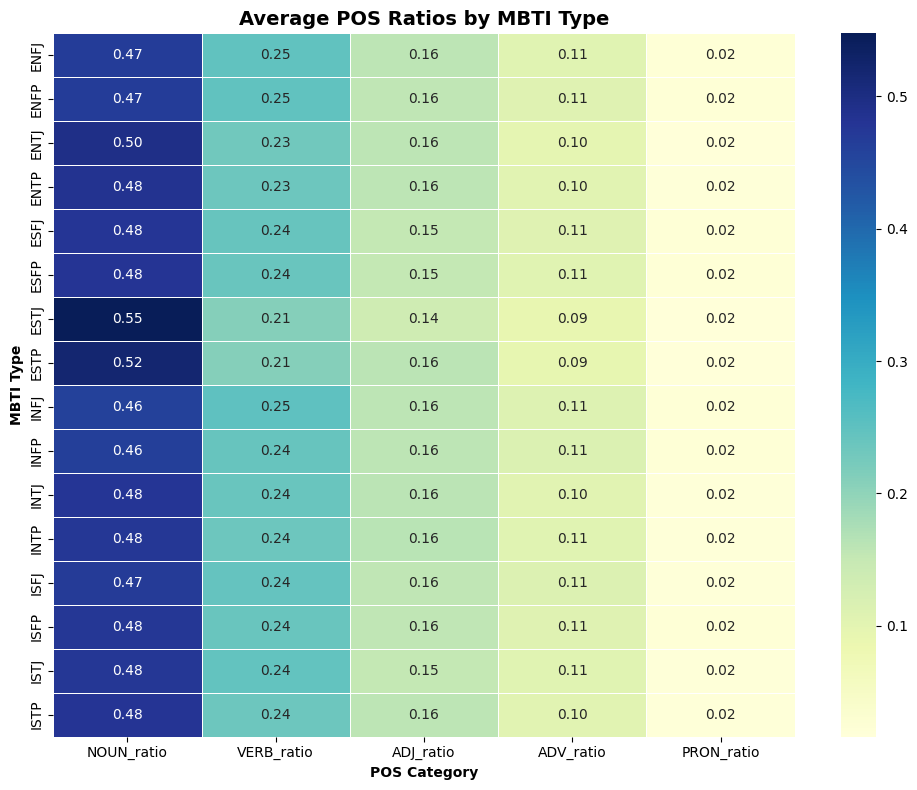

In [ ]:
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(pos_summary, annot=True, cmap="YlGnBu", fmt=".2f", linewidths=0.5)
plt.title("Average POS Ratios by MBTI Type", fontsize=14, fontweight='bold')
plt.xlabel("POS Category", fontweight='bold')
plt.ylabel("MBTI Type", fontweight='bold')
plt.tight_layout()
plt.show()

POS ratios remain **remarkably consistent** across all MBTI types, showing minimal linguistic variation.

| POS Tag | Approx. Range |
|----------|----------------|
| NOUN | 0.46–0.55 |
| VERB | 0.21–0.25 |
| ADJ | 0.14–0.16 |
| ADV | 0.09–0.11 |
| PRON | ~0.02 |

- The **narrow range** across all types suggests that **POS distribution is largely constant**, indicating minimal stylistic difference at this grammatical level.
- **ESTJ** shows a slightly higher **noun ratio (~0.55)**, possibly reflecting a more **object-oriented or concrete linguistic focus**, which aligns with its personality profile.  
  However, this finding should be **interpreted cautiously** due to small sample size and the **earlier anomaly** observed in the ESTJ data.
- **Pronoun ratios** are very low (<0.02) across all types, not due to personality differences, but because **stopword removal** eliminated most pronoun tokens. As a result, pronouns **cannot be meaningfully compared** between types.

**POS ratios** do not vary significantly among personality types, they are **unlikely to be strong predictive features** for MBTI classification.  
Future models will require **semantic, lexical, or contextual features** to capture more meaningful distinctions in linguistic behavior.

### TF-IDF Feature Importance

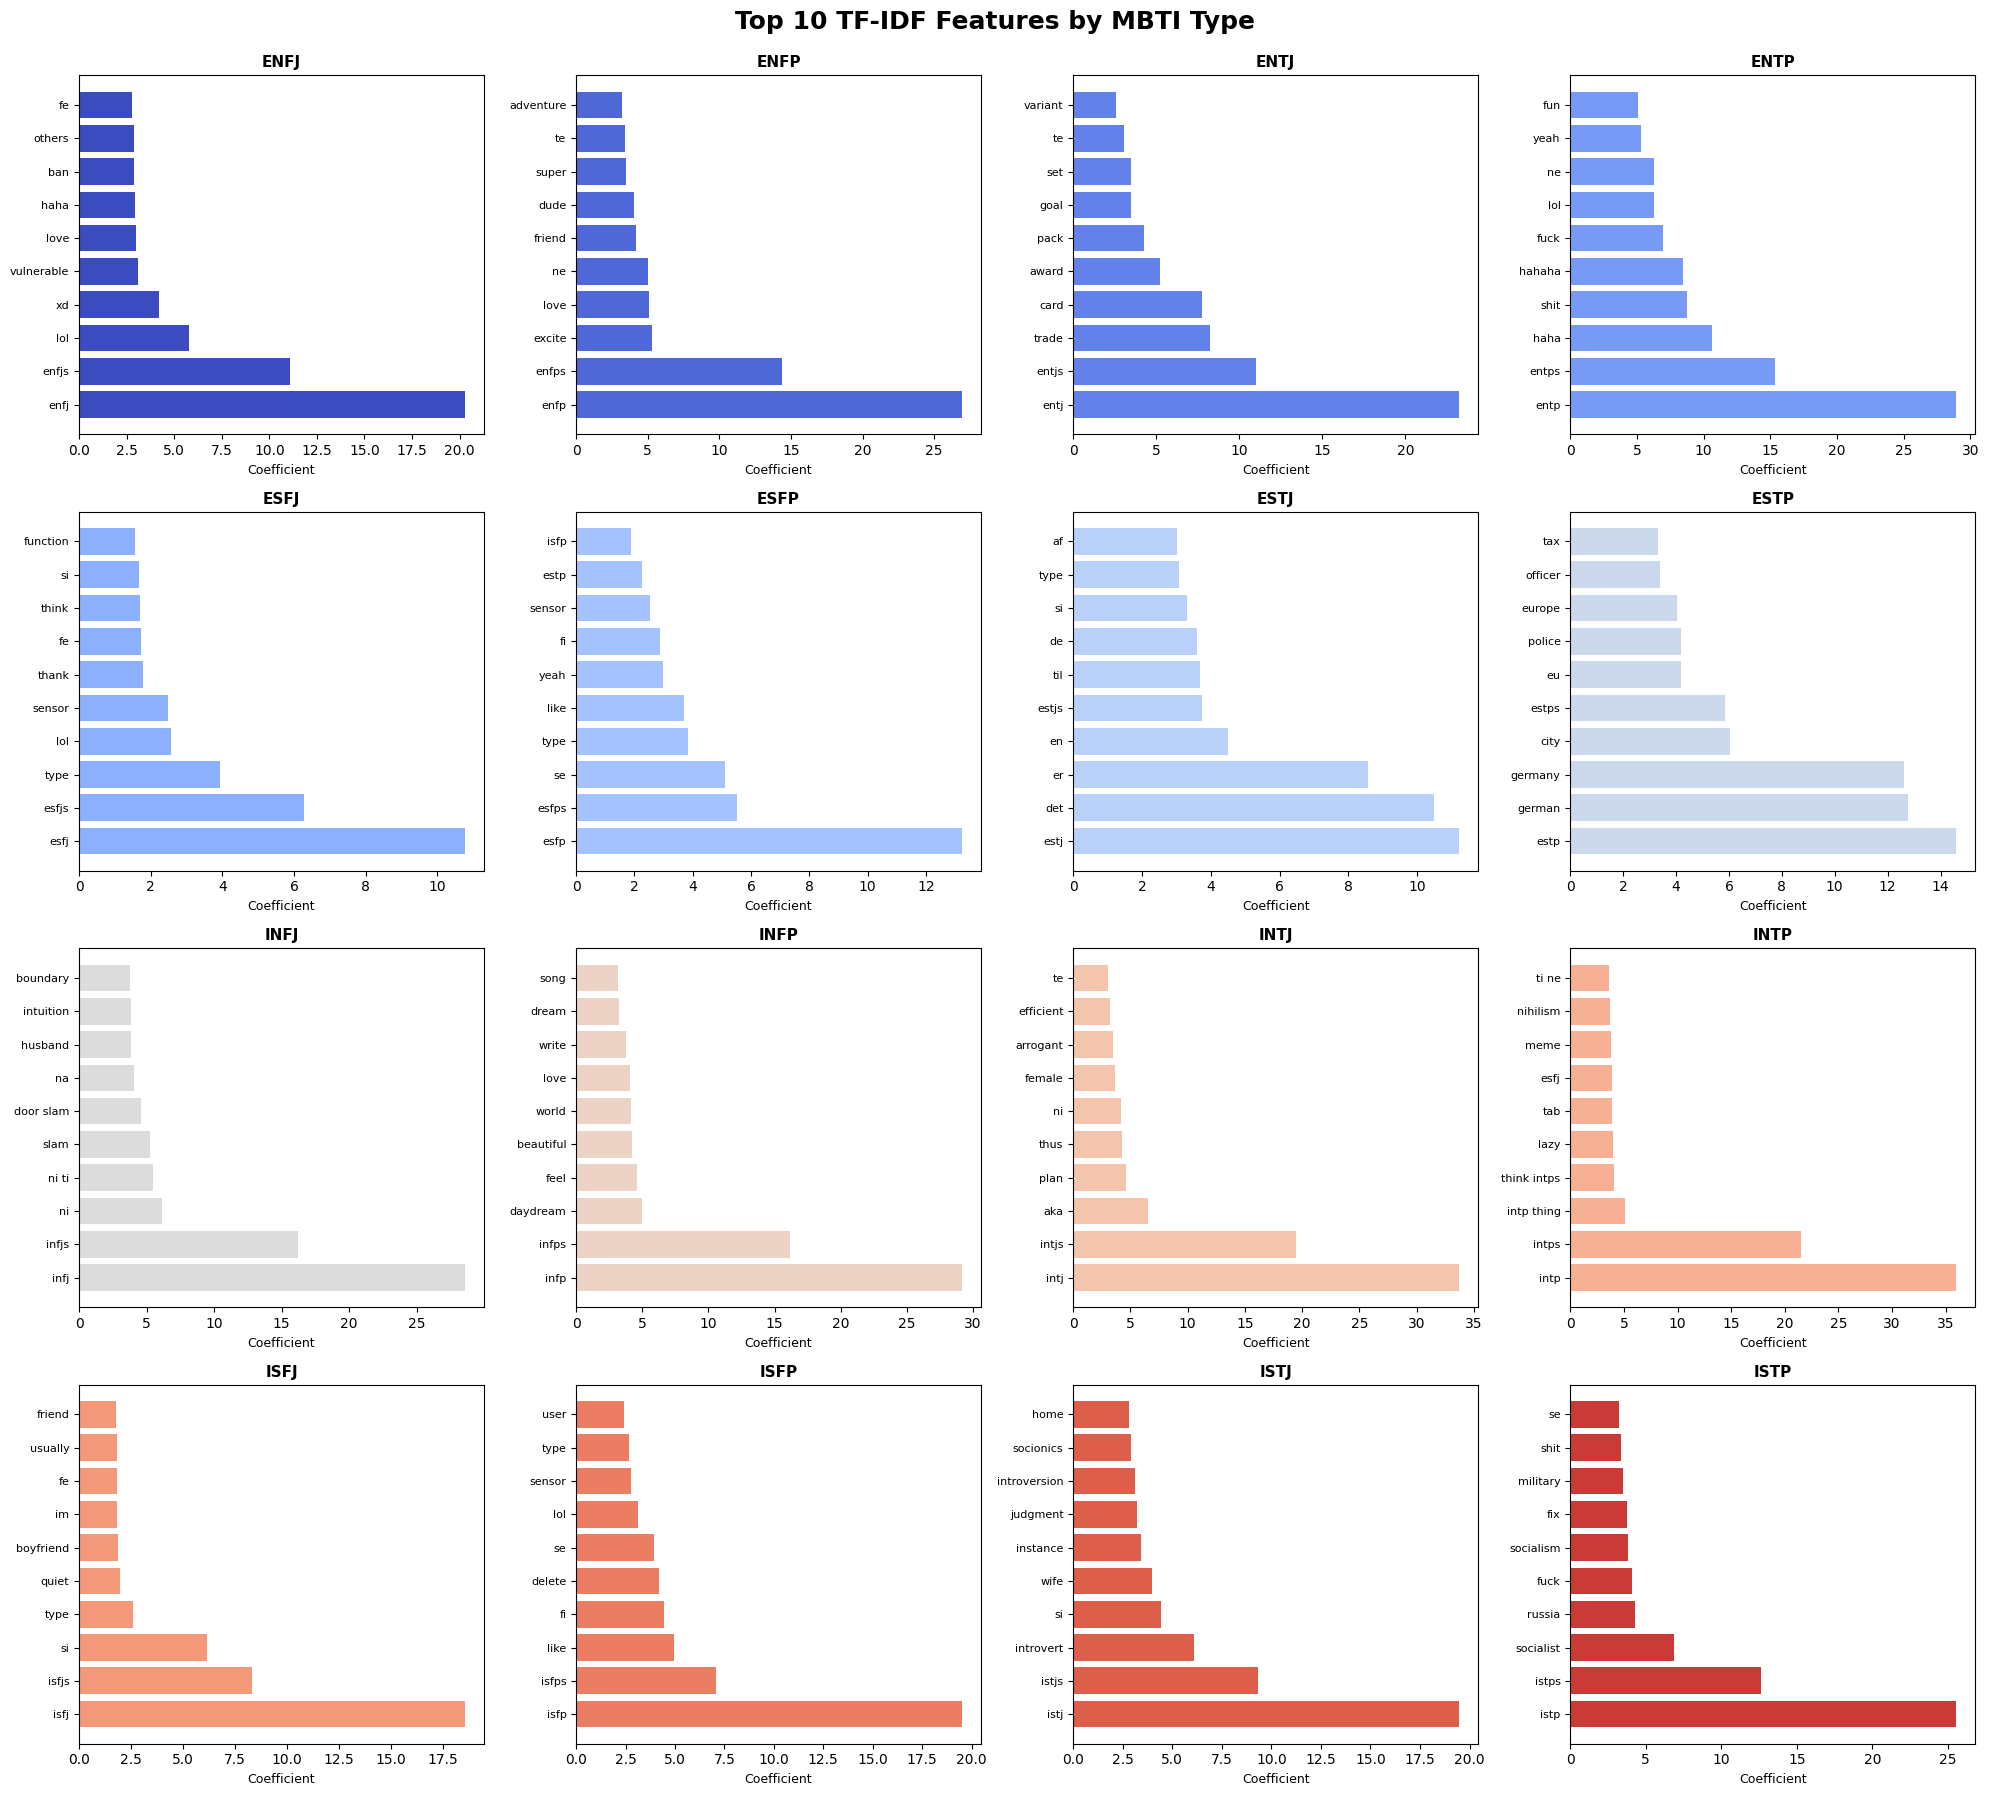

In [ ]:
import numpy as np

fig, axes = plt.subplots(4, 4, figsize=(20, 18))
axes = axes.flatten()

for idx, mbti_type in enumerate(clf.classes_):
    coefs = clf.coef_[idx]
    top_idx = np.argsort(coefs)[-10:]
    top_features = np.array(vectorizer.get_feature_names_out())[top_idx]
    top_weights = coefs[top_idx]

    axes[idx].barh(top_features, top_weights, color=plt.cm.coolwarm(idx/16))
    axes[idx].set_title(mbti_type, fontweight='bold', fontsize=11)
    axes[idx].invert_yaxis()
    axes[idx].set_xlabel("Coefficient", fontsize=9)
    axes[idx].tick_params(axis='y', labelsize=8)

plt.suptitle("Top 10 TF-IDF Features by MBTI Type", fontsize=18, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

The visualization above preents the **top 10 TF-IDF features** for each MBTI type.  

Each bar indicates the words most characteristic of that type’s writing within the dataset.

- **ENFP**: Terms such as *“excite,” “friend,” “adventure,”* and *“dude”* reflect an **expressive and socially engaged language style**, consistent with their imaginative and outward  oriented traits.  
- **ENTP**: High occurrence of **casual and profane language** suggests a **spontaneous and informal communication pattern**, typical of discussion driven or debate heavy exchanges.  
- **INTP**: Frequent words like *“think,” “meme,”* and *“philosophy”* indicate **introspective and conceptual writing**, supporting their analytical and reflective tendencies.  
- **INTJ**: Keywords *“arrogant,” “plan,”* and *“efficient”* emphasize a **goal oriented, structured, and evaluative tone**, aligning with their reputation for systematic reasoning.  
- **INFJ**: The phrase *“door slam”* notably appears among top features, a phrase often used within MBTI communities to describe emotional boundary-setting, reflecting **self-protective or decisive language use**.  
- **INFP**: Words like *“dream,” “love,” “beautiful,”* and *“daydream”* demonstrate **emotionally charged and imaginative vocabulary**, reinforcing their association with creative expression.  
- **ISFJ**: Common terms such as *“friend,” “quiet,”* and *“boyfriend”* point to **relationship oriented and reserved language**, indicating a focus on personal rather than abstract themes.  
- **ESTP**: Bigrams like *“lol,” “haha,”* and *“yeah”* reflect **reactive and conversational writing**, matching their action-focused, socially dynamic tendencies.  
- **ESTJ**: Terms such as *“officer,” “germany,”* and *“police”* suggest **structured and factual content**, though interpretation should remain cautious due to **limited sample size** and **previous multilingual anomalies** (e.g., *“det er”*).  


TF-IDF captures **distinct lexical markers** for larger classes (especially INFP, ENFP, INTP), while smaller classes are more **susceptible to topic or language bias**.  


Personality differentiation appears more **semantic than structural** tone, vocabulary, and abstraction level distinguish types more than syntactic or POS features.


TF-IDF provides clear interpretability and highlights personality linked lexical tendencies.  
However, due to overlapping vocabulary and community specific slang, **semantic and contextual modeling** would be required for stronger classification performance.


## 6. Ethical Considerations

**Data Privacy:** All posts are publicly available and anonymized.

**Bias Awareness:** Overrepresentation of certain types (e.g., INFP, INTP) may affect balance.

**Language & Cultural Bias:** Dataset is English only and Reddit centric.

**Responsible Interpretation:** Avoid generalizing results to real world psychological profiling.

Ethical handling ensures that insights remain educational, non diagnostic, and respect user privacy.

## 7. Conclusion

The linguistic exploration of the MBTI text dataset reveals a strong demographic and skew toward introverted–intuitive types, particularly INTP, INTJ, INFJ, and INFP. This reflects the nature of the data sources platforms, which is as Reddit and PersonalityCafe. It favor users who engage in introspective and abstract self expression discussions. The dataset does not represent the full MBTI spectrum equally, which limits the generalizability of linguistic findings, especially for underrepresented sensing types.

Across the four MBTI dimensions, the S/N axis displays the most extreme imbalance (91% Intuitive), followed by I/E (76% Introverted). The T/F and J/P dimensions remain relatively balanced, and therefore more suitable for linguistic modeling. Any personality based classification task should account for these imbalances through resampling, class weighting, and targeted evaluation metrics.

At the linguistic level, n-gram and POS analyses indicate that surface level features, such as word frequency or POS distribution, vary minimally across types. Common phrases such as “feel like” dominate nearly all categories, suggesting a shared discourse style rooted in online communication norms rather than personality. Anomalies such as the ESTJ bigram “det er” underscore the importance of language filtering and sample size sensitivity in interpreting results. Similarly, POS ratios remain nearly constant (e.g. NOUN ≈ 0.46–0.55, VERB ≈ 0.21–0.25), confirming that grammatical structure is not a big differentiator among types.

In contrast, TF-IDF analysis highlights clear lexical distinctions at the semantic level. Terms associated with abstract reasoning (INTP, INTJ), emotional or imaginative expression (INFP, ENFP), and interpersonal focus (ISFJ, ESFJ) align with personality based expectations. These findings suggest that meaningful differentiation emerges from semantic content rather than syntactic form.

Overall, while the dataset supports broad associations between language and personality, its imbalance and community specific bias constrains the predictive reliability. Future work should instead prioritize balanced data collection, multilingual filtering, and the inclusion of context aware linguistic features to capture deeper psychological and semantic patterns beyond surface level text statistics.